<a href="https://colab.research.google.com/github/Le4o/topicos-avancados-ic/blob/main/Avalia%C3%A7%C3%A3o_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação 1
#### Exercício da matéria de Tópicos Avançados em Inteligência Computacional

Grupo:
- João Victor de Sledz Bulhões
- Leonardo de Andrade Santana
- Lis da Silva Azevedo

### Definição do Exercício
Utilizaremos o banco de dados do Human Activity Recognition with Smartphones, que foi construído a partir das gravações dos participantes do estudo realizando atividades da vida diária enquanto carregavam um smartphone com sensores inerciais embutidos. Para cada registro no conjunto de dados, é fornecido:

- Aceleração triaxial do acelerômetro (aceleração total) e a aceleração corporal estimada.

- Velocidade angular triaxial do giroscópio.

- Um vetor de 561 atributos com variáveis de domínio de tempo e frequência.

- O rótulo da atividade.

### Objetivo:
* Construir um modelo robusto para classificação das atividades diárias, utilizando o banco de dados fornecido, em uma das seis ações disponíveis:
> 1. caminhar;
> 2. subir escadas;
> 3. descer escadas;
> 4. sentar;
> 5. ficar em pé;
> 6. deitar.

* Desenvolver 4 modelos, utilizando:
> 1. Multi-Layer Perceptron (MLP)
> 2. Convolutional Neural Network (CNN)
> 3. Recurrent Neural Network (RNN)
> 4. Arquitetura hibrida com a combinação das redes anteriore

* Considere a divisão entre treinamento, validação e teste de 50%, 25% e 25%, respectivamente.

* Utilizar como métricas: **precision, recall, specificity,
F1-Score e accuracy**, evidenciando que o modelo não sofreu de **over/underfitting**.

### Observação: 
*   *Apresentação de métricas, gráficos, são essenciais para entendimento dos modelos e justificativas.*
*   *Compare ao final em uma tabela e apresente que técnica obteve os melhores
resultados, discutindo-os à luz de seu conhecimento sobre o assunto, discutindo
se eram resultados esperados, se estão adequados, e os porquês.*

### Opcionais:

*   A utilização de redes neurais baseadas em transformers é opcional e adicionará **1,0 ponto extra** ao projeto.
*   A utilização de pré-processamento das séries com Wavelets OU transformadas de Fourier adicionará **1,0 ponto extra** ao projeto.


### Link:

* [Mais informações sobre os recursos estão disponíveis no site](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) 


In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Datasets

Mounted at /content/drive/
/content/drive/My Drive/Datasets


In [27]:
!pip install tensorflow_addons keras_metrics
import numpy as np 
import pandas as pd 
import tensorflow as tf
import tensorflow_addons as tfa
import keras_metrics
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
tf.get_logger().setLevel('ERROR')

## Carregando os dados

O dataset fornecido é segmentado em **70% treino e 30% teste**, porém a atividade pede para segmentar em: **50% treino, 25% validação e 25% teste.** Então nos primeiramente juntamos os dados.


In [3]:
# Carregando os dados diretamente dos csvs do Human Activity Recognition with Smartphones
train_data = pd.read_csv('./uci_har_csvs/train.csv')
test_data = pd.read_csv('./uci_har_csvs/test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

data = train_data.append(test_data)
data.shape

print(f'Shape of combined data is {data.shape}')

Shape of train data is: (7352, 563)
Shape of test data is: (2947, 563)
Shape of combined data is (10299, 563)


## Analise inicial dos dados

O dataset possui 6 classes, sendo elas:


1.   Walking downstairs
2.   Walking Upstairs
3.   Walking
4.   Sitting
5.   Stading 
6.   Laying



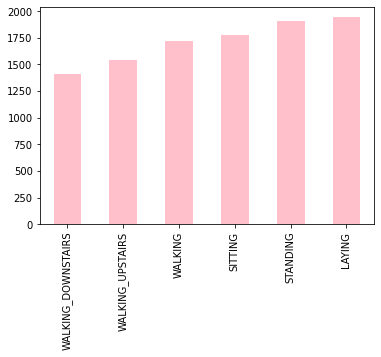

In [4]:
class_count = len(data['Activity'].unique())
data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'pink')

## Segmentação do Dataset

50% treino, 25% validação e 25% teste


In [5]:
train, validate, test = \
              np.split(data.sample(frac=1, random_state=42), 
                       [int(.5*len(data)), int(.75*len(data))])
              
print(f'Shape of train data is {train.shape}')
print(f'Shape of validation data is {validate.shape}')
print(f'Shape of test data is {test.shape}')
validate.head()

Shape of train data is (5149, 563)
Shape of validation data is (2575, 563)
Shape of test data is (2575, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
2117,0.274369,-0.016706,-0.110229,-0.991515,-0.989040,-0.978536,-0.992510,-0.990249,-0.980843,-0.936067,-0.561457,-0.812424,0.841441,0.691739,0.824627,-0.989752,-0.999926,-0.999935,-0.999490,-0.994133,-0.991564,-0.983694,-0.570835,-0.632256,-0.525435,0.194450,-0.146492,-0.041534,0.385220,0.146668,0.008702,0.117522,0.316987,0.049494,0.002990,0.077043,-0.040535,-0.326617,-0.124434,-0.467705,...,-1.000000,-1.000000,0.189798,-0.435028,-0.826468,-0.983336,-0.983446,-0.979036,-0.988786,-0.996133,-0.983336,-0.999768,-0.973804,-0.651509,-1.0,-0.200696,-0.692462,-0.925401,-0.990613,-0.989842,-0.989335,-0.990264,-0.995010,-0.990613,-0.999922,-0.988997,-0.923452,-1.000000,-0.165418,-0.227327,-0.592258,-0.031017,-0.068529,0.222656,-0.171256,0.365294,-0.846661,-0.004809,11,LAYING
2937,0.260018,-0.008491,-0.117588,-0.935685,-0.670521,-0.875247,-0.959882,-0.805597,-0.907493,-0.892596,-0.146449,-0.774665,0.710398,0.541556,0.691246,-0.910007,-0.997606,-0.978016,-0.991313,-0.995422,-0.989595,-0.963853,-0.310086,-0.398456,-0.248864,-0.508756,0.476951,-0.460860,0.392226,-0.604299,0.591770,-0.713939,0.839213,-0.252033,0.355529,-1.000000,1.000000,0.296486,-0.012320,-0.867214,...,-0.476360,-1.000000,-0.455206,0.384570,0.087227,-0.512505,-0.269562,-0.408939,-0.192944,-0.049099,-0.512505,-0.740628,-0.801698,0.130729,-1.0,-0.259452,0.265055,-0.064927,-0.929913,-0.863376,-0.907363,-0.843969,-0.985603,-0.929913,-0.993913,-0.935197,-0.419270,-1.000000,-0.563006,0.783258,0.551519,0.351286,0.079468,0.329166,0.006809,-0.885412,0.113755,0.100170,16,SITTING
6867,0.278964,-0.016177,-0.112617,-0.986395,-0.993402,-0.996253,-0.987809,-0.994375,-0.995559,-0.935219,-0.566172,-0.826331,0.838379,0.692073,0.845662,-0.992035,-0.999849,-0.999965,-0.999920,-0.989898,-0.995405,-0.992992,-0.391655,-0.668624,-0.735404,0.074098,-0.024003,-0.086759,-0.050424,0.497133,-0.308945,0.436123,-0.284634,0.562480,-0.303941,0.243113,-0.238292,-0.560531,-0.482763,0.529234,...,-1.000000,-0.746032,0.201563,-0.661723,-0.919496,-0.963026,-0.936948,-0.955237,-0.922671,-0.973526,-0.963026,-0.998002,-0.980297,-0.

## Preparando os Dados para os Modelos

*   **x** = Todos os conjuntos de dados tirando as duas ultimas colunas.
*   **y** = Ultima coluna, coluna que define a atividade.



In [77]:
# Separando os os dados do target
x_train, y_train = train.iloc[:, :-2], train.iloc[:, -1:]
x_validate, y_validate = validate.iloc[:, :-2], validate.iloc[:, -1:]
x_test, y_test = test.iloc[:, :-2], test.iloc[:, -1:]
print(f'Train: {x_train.shape}, {y_train.shape}\nValidation: {x_validate.shape}, {y_validate.shape}\nTraining: {x_test.shape}, {y_test.shape}\n')

Train: (5149, 561), (5149, 1)
Validation: (2575, 561), (2575, 1)
Training: (2575, 561), (2575, 1)



Os modelos aceitam apenas números, então foi necessário alterar as strings que definem as classes para números.

In [78]:
# Trasformando as strings do target em números
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_validate = le.fit_transform(y_validate)
y_test = le.fit_transform(y_test)

# --------------Não sei oq é isso
scaling_data = MinMaxScaler()
x_train = scaling_data.fit_transform(x_train)
x_validate = scaling_data.fit_transform(x_validate)
x_test = scaling_data.transform(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
# Separando casos de teste do tipo LAYING
test_laying = test[test.Activity == 'LAYING']
x_test_laying, y_test_laying = test_laying.iloc[:, :-2], test_laying.iloc[:, -1:]
y_test_laying = le.fit_transform(y_test_laying)
x_test_laying = scaling_data.fit_transform(x_test_laying)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
def print_metrics(test_results):
    print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[4]}\nSpecificity: {test_results[5]}')

In [29]:
def plot_loss(history, epochs):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(epochs)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [121]:
def plot_bar_graph(model_name, values, label, ord):
    plt.subplot(ord[0], ord[1], ord[2])
    plt.bar(model_name, values, color ='blue', width = 0.1)
    plt.xlabel("Models")
    plt.ylabel(label)
    plt.title("Comparing {} by models".format(label))

# Multi-Layer Perceptron (MLP)

Perceptron é utilizado para classificação binária, possuindo apenas 1 neurônio, sendo assim, não podendo se aplicar a dados não lineares. 
O MLP foi desenvolvido para suprir com essa limitação.Ele possui camadas de entrada e saída e uma ou mais camadas ocultas com muitos neurônios juntos. E enquanto no Perceptron o neurônio deve ter uma função de ativação que impõe um limite, como ReLU ou sigmoid, os neurônios em um MLP podem usar qualquer função de ativação arbitrária.

Funções de ativação: 
*   **ReLU**: Função não linear que a não ativa todos os neurônios ao mesmo tempo. Se a entrada for negativa, ela será convertida em zero e o neurônio não será ativado. Isso significa que, ao mesmo tempo, apenas alguns neurônios são ativados, tornando a rede esparsa e eficiente e fácil para a computação.
*   **Softmax**: Alternativa para função sigmóide para lidar com problemas de classificação, já que a mesma é capaz de lidar com mais de 2 classes, diferente da sigmóide.




In [36]:
# Criando o model
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=x_train.shape[1])) # Layer 1
model_mlp.add(Dropout(0.25))
model_mlp.add(Dense(64, activation='relu')) # Layer 2
model_mlp.add(Dropout(0.25))
model_mlp.add(Dense(6, activation='softmax')) # Layer 3



*   **Compilação, Treino e validação**: O processo de treino foi composto por 20 epocas e 50% do dataset e a validação por 25% do dataset. 
>* Optimizer: [**Adam**](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) é um algoritmo de otimização que pode ser usado em vez do procedimento clássico de *Stochastic Gradient Descent* (mantém uma única taxa de aprendizado para todas as atualizações de peso e a taxa de aprendizado não muda durante o treinamento) para atualizar os pesos da rede iterativos com base nos dados de treinamento.
>* Loss: [sparse_categorical_crossentropy](https://vitalflux.com/keras-categorical-cross-entropy-loss-function/) Usado para modelos de classificação multi-classes quando a output label  sao valores inteiros (0, 1, 2,..).


In [37]:
# Compilando o model e treinando
model_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 
                                                                                     keras_metrics.sparse_categorical_precision(), 
                                                                                     keras_metrics.sparse_categorical_recall(), 
                                                                                     keras_metrics.sparse_categorical_f1_score(), 
                                                                                     keras_metrics.sparse_categorical_true_negative()]) # optimizer 'adam'
history_mlp = model_mlp.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_validate, y_validate)) # teinando e validando 

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 2s 10ms/step - loss: 1.1174 - accuracy: 0.5372 - precision: 0.6692 - recall: 0.2031 - f1_score: 0.2959 - true_negative: 2060.1729 - val_loss: 0.5778 - val_accuracy: 0.7965 - val_precision: 0.8913 - val_recall: 0.5331 - val_f1_score: 0.6663 - val_true_negative: 5173.4390
Epoch 2/20
81/81 [==============================] - 0s 5ms/step - loss: 0.5607 - accuracy: 0.7669 - precision: 0.9230 - recall: 0.6827 - f1_score: 0.7844 - true_negative: 8257.8516 - val_loss: 0.3677 - val_accuracy: 0.8656 - val_precision: 0.9374 - val_recall: 0.7639 - val_f1_score: 0.8418 - val_true_negative: 11370.9268
Epoch 3/20
81/81 [==============================] - 0s 4ms/step - loss: 0.3865 - accuracy: 0.8444 - precision: 0.9441 - recall: 0.8110 - f1_score: 0.8724 - true_negative: 14456.1729 - val_loss: 0.2759 - val_accuracy: 0.8901 - val_precision: 0.9497 - val_recall: 0.8426 - val_f1_score: 0.8929 - val_true_negative: 17578.5605
Epoch 4/20
81/81 [=======================

Testando o modelo com dataset de teste que equivale 50% do dataset total

In [38]:
# Testa o treino com todas as classes
all_results_mlp = model_mlp.evaluate(x_test, y_test, verbose=1)
print_metrics(all_results_mlp)

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 1s 2ms/step - loss: 0.0928 - accuracy: 0.9627 - precision: 0.9863 - recall: 0.9748 - f1_score: 0.9805 - true_negative: 125795.3125
Loss: 0.09276573359966278
Accuracy: 0.9627184271812439
Precision: 0.986291229724884
Recall: 0.974826455116272
F1 Score: 0.9805253744125366
Specificity: 125795.3125


In [39]:
# Testa o treino apenas com a classe LAYING
laying_results_mlp = model_mlp.evaluate(x_test_laying, y_test_laying, verbose=1)
print_metrics(laying_results_mlp)

15/15 [==============================] - 0s 3ms/step - loss: 0.4576 - accuracy: 0.8761 - precision: 0.9865 - recall: 0.9741 - f1_score: 0.9803 - true_negative: 126818.0000
Loss: 0.4576440155506134
Accuracy: 0.8760504126548767
Precision: 0.9865047335624695
Recall: 0.9741455912590027
F1 Score: 0.9802860021591187
Specificity: 126818.0


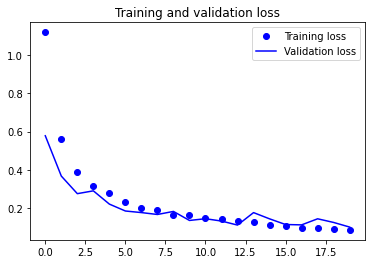

In [40]:
plot_loss(history_mlp, 20)

# Convolutional Neural Network (CNN)
Uma **Artificial Neural Network (ANN)** é uma série de algoritmos que se esforçam para reconhecer relacionamentos subjacentes em um conjunto de dados, por meio de um processo que imita a maneira como o cérebro humano opera. As **ANN** podem se adaptar a mudanças de entrada para que a rede gere o melhor resultado possível sem a necessidade de redesenhar os critérios de saída.

As **Convolutional Neural Network (CNN)** são um tipo especializado de ANN que usam convolução no lugar da multiplicação geral da matriz em pelo menos uma de suas camadas.

In [80]:
n_timesteps, n_features, n_outputs = x_train.shape[0], x_train.shape[1], y_train.shape[0]

# Adicionando mais uma dimensão a x, para ficarem 3, como é pedido no Conv1D
x_train_cnn = x_train[..., None]
x_validate_cnn = x_validate[..., None]

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=x_train_cnn.shape[1:]))
model_cnn.add(Dropout(0.2))
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(10, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',
                                                                                     keras_metrics.sparse_categorical_precision(), 
                                                                                     keras_metrics.sparse_categorical_recall(), 
                                                                                     keras_metrics.sparse_categorical_f1_score(), 
                                                                                     keras_metrics.sparse_categorical_true_negative()])
history_cnn = model_cnn.fit(x_train_cnn, y_train, batch_size=64, epochs=20, validation_data=(x_validate_cnn, y_validate))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 17s 196ms/step - loss: 0.7584 - accuracy: 0.6838 - precision: 0.7793 - recall: 0.3835 - f1_score: 0.4934 - true_negative: 2101.0247 - val_loss: 0.3248 - val_accuracy: 0.8940 - val_precision: 0.9871 - val_recall: 0.7520 - val_f1_score: 0.8534 - val_true_negative: 5240.6343
Epoch 2/20
81/81 [==============================] - 16s 194ms/step - loss: 0.2337 - accuracy: 0.9085 - precision: 0.9878 - recall: 0.8411 - f1_score: 0.9084 - true_negative: 8347.4199 - val_loss: 0.2271 - val_accuracy: 0.9049 - val_precision: 0.9900 - val_recall: 0.8836 - val_f1_score: 0.9338 - val_true_negative: 11484.8291
Epoch 3/20
81/81 [==============================] - 15s 187ms/step - loss: 0.1554 - accuracy: 0.9398 - precision: 0.9919 - recall: 0.9072 - f1_score: 0.9477 - true_negative: 14605.4199 - val_loss: 0.1438 - val_accuracy: 0.9441 - val_precision: 0.9933 - val_recall: 0.9238 - val_f1_score: 0.9573 - val_true_negative: 17738.8301
Epoch 4/20
81/81 [===============

In [81]:
# Testando o model após treinamento
x_test_cnn = x_test[..., None]
all_results_cnn = model_cnn.evaluate(x_test, y_test, verbose=1)
print_metrics(all_results_cnn)

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 2s 22ms/step - loss: 0.0656 - accuracy: 0.9748 - precision: 0.9987 - recall: 0.9890 - f1_score: 0.9938 - true_negative: 126157.3125
Loss: 0.0656018778681755
Accuracy: 0.9747572541236877
Precision: 0.9986695647239685
Recall: 0.9889505505561829
F1 Score: 0.9937862157821655
Specificity: 126157.3125


In [82]:
# Testa o treino apenas com a classe LAYING
laying_results_cnn = model_cnn.evaluate(x_test_laying, y_test_laying, verbose=1)
print_metrics(laying_results_cnn)

15/15 [==============================] - 0s 19ms/step - loss: 0.5002 - accuracy: 0.9160 - precision: 0.9987 - recall: 0.9885 - f1_score: 0.9935 - true_negative: 127180.0000
Loss: 0.5001770853996277
Accuracy: 0.9159663915634155
Precision: 0.9986905455589294
Recall: 0.9884522557258606
F1 Score: 0.9935449361801147
Specificity: 127180.0


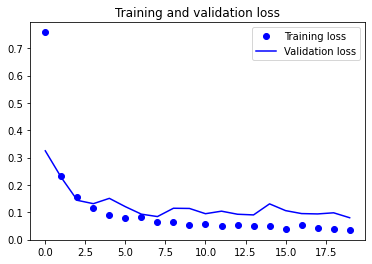

In [83]:
plot_loss(history_cnn, 20)

# Recurrent Neural Network (RNN)

**Recurrent Neural Network (RNN)** tem uma conexão recorrente no *hidden state*. Essa restrição de loop garante que as informações sequenciais sejam capturadas nos dados de entrada.

In [70]:
x_train_rnn = x_train[..., None]
x_validate_rnn = x_validate[..., None]

model_rnn2 = keras.models.Sequential()
model_rnn2.add(keras.Input(shape=x_train_rnn.shape[1:])) 
model_rnn2.add(layers.SimpleRNN(128, return_sequences=True, activation='relu'))
model_rnn2.add(Dropout(0.2))
model_rnn2.add(Flatten())
model_rnn2.add(layers.Dense(10))

model_rnn2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 561, 128)          16640     
                                                                 
 dropout_10 (Dropout)        (None, 561, 128)          0         
                                                                 
 flatten_5 (Flatten)         (None, 71808)             0         
                                                                 
 dense_13 (Dense)            (None, 10)                718090    
                                                                 
Total params: 734,730
Trainable params: 734,730
Non-trainable params: 0
_________________________________________________________________


In [71]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy", 
            keras_metrics.sparse_categorical_precision(), 
            keras_metrics.sparse_categorical_recall(), 
            keras_metrics.sparse_categorical_f1_score(), 
            keras_metrics.sparse_categorical_true_negative()]

model_rnn2.compile(loss=loss, optimizer=optim, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [72]:
history_rnn2 = model_rnn2.fit(
    x_train_rnn, y_train, validation_data=(x_validate_rnn, y_validate), batch_size=64, epochs=10
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 31s 366ms/step - loss: 0.4413 - accuracy: 0.8151 - precision: 1.7036 - recall: 5.8937 - f1_score: 2.5688 - true_negative: 3842.1604 - val_loss: 0.1874 - val_accuracy: 0.9212 - val_precision: 19.1559 - val_recall: 9.2248 - val_f1_score: 11.6018 - val_true_negative: 15940.1709
Epoch 2/10
81/81 [==============================] - 28s 351ms/step - loss: 0.1197 - accuracy: 0.9559 - precision: 27.6971 - recall: 10.6286 - f1_score: -28.5315 - true_negative: 30207.6055 - val_loss: 0.1051 - val_accuracy: 0.9604 - val_precision: -5.2462 - val_recall: 11.3813 - val_f1_score: -21.1233 - val_true_negative: 48471.9023
Epoch 3/10
81/81 [==============================] - 30s 365ms/step - loss: 0.0826 - accuracy: 0.9676 - precision: -3.6926 - recall: 11.9123 - f1_score: -10.7655 - true_negative: 67148.7656 - val_loss: 0.2268 - val_accuracy: 0.9181 - val_precision: -2.6084 - val_recall: 12.3456 - val_f1_score: -6.6278 - val_true_negative: 89229.9062
Epoch 4/10
81/

In [73]:
all_results_rnn = model_rnn2.evaluate(x_test, y_test, batch_size=64, verbose=2)
print_metrics(all_results_rnn)

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


41/41 - 4s - loss: 0.1694 - accuracy: 0.9437 - precision: -1.0925e+00 - recall: 15.1018 - f1_score: -2.3553e+00 - true_negative: 495325.0312 - 4s/epoch - 109ms/step
Loss: 0.1694183200597763
Accuracy: 0.9436893463134766
Precision: -1.0924532413482666
Recall: 15.10184097290039
F1 Score: -2.3553123474121094
Specificity: 495325.03125


In [74]:
# Testa o treino apenas com a classe LAYING
laying_results_rnn = model_rnn2.evaluate(x_test_laying, y_test_laying, verbose=1)
print_metrics(laying_results_rnn)

15/15 [==============================] - 1s 60ms/step - loss: 0.9207 - accuracy: 0.7794 - precision: -1.1003 - recall: 15.0308 - f1_score: -2.3744 - true_negative: 506858.0000
Loss: 0.9207347631454468
Accuracy: 0.779411792755127
Precision: -1.1002615690231323
Recall: 15.030759811401367
F1 Score: -2.374375820159912
Specificity: 506858.0


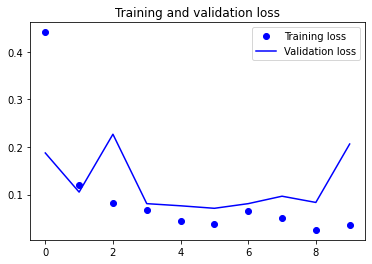

In [75]:
plot_loss(history_rnn2, 10)

# Modelo Híbrido
Criando modelo híbrido

In [84]:
x_train = x_train[..., None]
x_validate = x_validate[..., None]

model_hyb = Sequential()
# Model RNN
model_hyb.add(keras.Input(shape=x_train_rnn.shape[1:])) 
model_hyb.add(layers.SimpleRNN(128, return_sequences=True, activation='relu'))
# Model CNN
model_hyb.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_hyb.add(Dropout(0.2))
model_hyb.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model_hyb.add(Dropout(0.2))
model_hyb.add(MaxPooling1D(pool_size=2))
model_hyb.add(Dropout(0.2))
model_hyb.add(Flatten())
# Model MLP
model_hyb.add(Dense(64, activation='relu')) # Layer 1
model_hyb.add(Dropout(0.2))
model_hyb.add(Dense(64, activation='relu')) # Layer 2
model_hyb.add(Dropout(0.2))
model_hyb.add(Dense(10, activation='softmax'))

model_hyb.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 561, 128)          16640     
                                                                 
 conv1d_11 (Conv1D)          (None, 560, 64)           16448     
                                                                 
 dropout_17 (Dropout)        (None, 560, 64)           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 559, 64)           8256      
                                                                 
 dropout_18 (Dropout)        (None, 559, 64)           0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 279, 64)          0         
 1D)                                                             
                                                     

In [85]:
model_hyb.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',
                                                                                      keras_metrics.sparse_categorical_precision(), 
                                                                                      keras_metrics.sparse_categorical_recall(), 
                                                                                      keras_metrics.sparse_categorical_f1_score(), 
                                                                                      keras_metrics.sparse_categorical_true_negative()])
history = model_hyb.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_validate, y_validate))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


81/81 [==============================] - 49s 580ms/step - loss: 0.9893 - accuracy: 0.5622 - precision: 0.6027 - recall: 0.3588 - f1_score: 0.4400 - true_negative: 2039.0247 - val_loss: 0.2999 - val_accuracy: 0.8854 - val_precision: 0.8873 - val_recall: 0.7263 - val_f1_score: 0.7986 - val_true_negative: 5140.0977
Epoch 2/20
81/81 [==============================] - 46s 571ms/step - loss: 0.3309 - accuracy: 0.8670 - precision: 0.9265 - recall: 0.8242 - f1_score: 0.8723 - true_negative: 8236.7900 - val_loss: 0.1661 - val_accuracy: 0.9301 - val_precision: 0.9475 - val_recall: 0.8717 - val_f1_score: 0.9080 - val_true_negative: 11378.4395
Epoch 3/20
81/81 [==============================] - 44s 549ms/step - loss: 0.1903 - accuracy: 0.9229 - precision: 0.9575 - recall: 0.8979 - f1_score: 0.9267 - true_negative: 14476.9873 - val_loss: 0.1450 - val_accuracy: 0.9367 - val_precision: 0.9646 - val_recall: 0.9148 - val_f1_score: 0.9391 - val_true_negative: 17624.8789
Epoch 4/20
81/81 [===============

In [86]:
# Testando o model após treinamento
x_test_rnn2 = x_test[..., None]
all_results_hyb = model_hyb.evaluate(x_test_rnn2, y_test, verbose=1)
print_metrics(all_results_hyb)

81/81 [==============================] - 6s 71ms/step - loss: 0.0764 - accuracy: 0.9751 - precision: 0.9937 - recall: 0.9865 - f1_score: 0.9901 - true_negative: 126011.3125
Loss: 0.07641921192407608
Accuracy: 0.9751456379890442
Precision: 0.993703305721283
Recall: 0.9865180253982544
F1 Score: 0.9900975823402405
Specificity: 126011.3125


In [87]:
# Testa o treino apenas com a classe LAYING
laying_results_hyb = model_hyb.evaluate(x_test_laying, y_test_laying, verbose=1)
print_metrics(laying_results_hyb)

/usr/local/lib/python3.7/dist-packages/keras_metrics/metrics.py:26: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return object.__getattribute__(self, name)


15/15 [==============================] - 2s 74ms/step - loss: 0.3621 - accuracy: 0.9391 - precision: 0.9938 - recall: 0.9863 - f1_score: 0.9900 - true_negative: 127034.0000
Loss: 0.3620908260345459
Accuracy: 0.9390756487846375
Precision: 0.9938051700592041
Recall: 0.9862940907478333
F1 Score: 0.990035355091095
Specificity: 127034.0


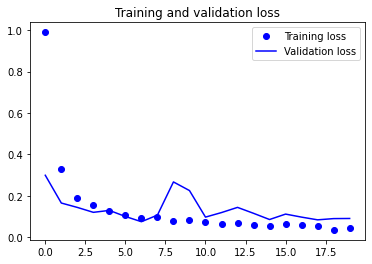

In [88]:
plot_loss(history, 20)

# Dados

In [129]:
loss = {
  'MLP': laying_results_mlp[0], 
  'CNN': laying_results_cnn[0], 
  'RNN': laying_results_rnn[0], 
  'Hybrid': laying_results_hyb[0]
}
accuracy = {
    'MLP': laying_results_mlp[1], 
    'CNN': laying_results_cnn[1], 
    'RNN': laying_results_rnn[1], 
    'Hybrid': laying_results_hyb[1]
}

precision = {
    'MLP': laying_results_mlp[2], 
    'CNN': laying_results_cnn[2], 
    'RNN': laying_results_rnn[2], 
    'Hybrid': laying_results_hyb[2]
}

recall = {
    'MLP': laying_results_mlp[3], 
    'CNN': laying_results_cnn[3], 
    'RNN': laying_results_rnn[3], 
    'Hybrid': laying_results_hyb[3]
}

f1_score = {
    'MLP': laying_results_mlp[4], 
    'CNN': laying_results_cnn[4], 
    'RNN': laying_results_rnn[4], 
    'Hybrid': laying_results_hyb[4]
}

specificity = {
    'MLP': laying_results_mlp[5], 
    'CNN': laying_results_cnn[5], 
    'RNN': laying_results_rnn[5], 
    'Hybrid': laying_results_hyb[5]
}

# Conclusão



![image.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/table.png)

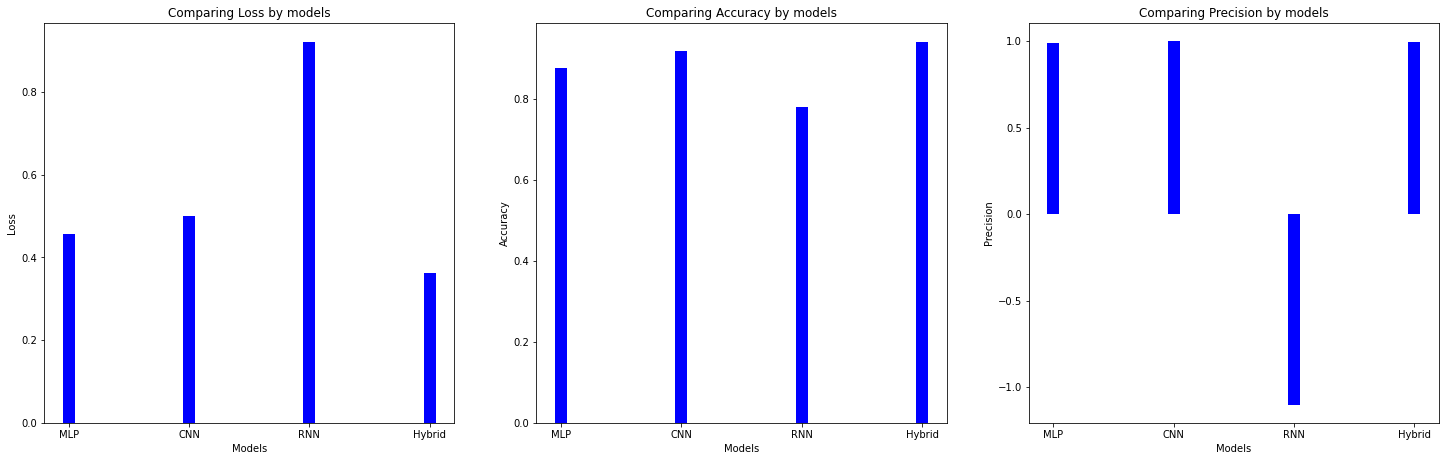

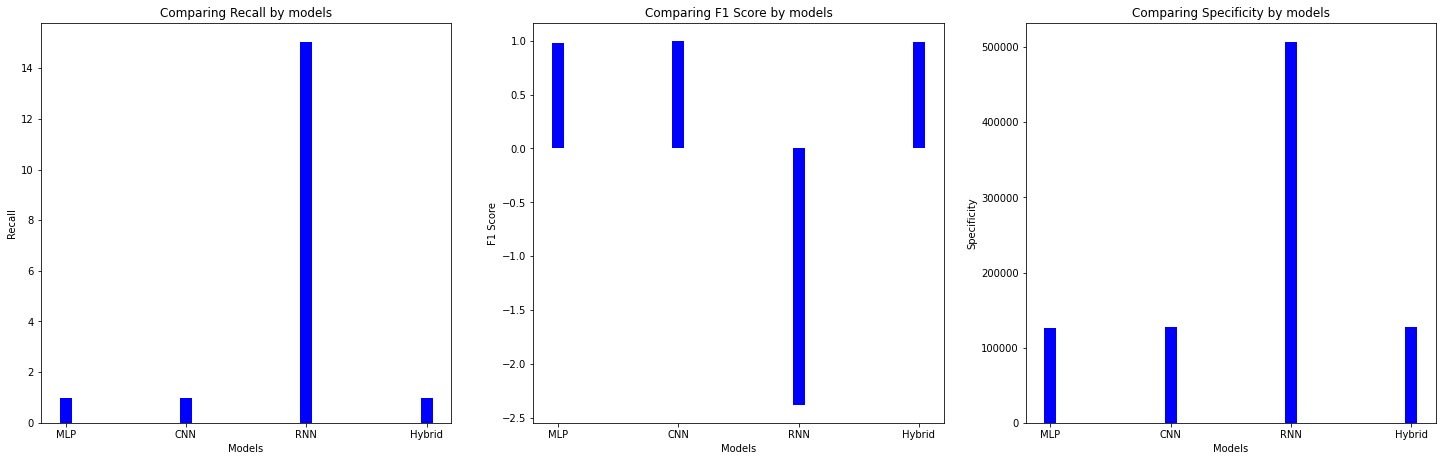

In [130]:
plt.figure(figsize=(25, 25))
plot_bar_graph(list(loss.keys()), list(loss.values()), "Loss", [3, 3, 1])
plot_bar_graph(list(accuracy.keys()), list(accuracy.values()), "Accuracy",  [3, 3, 2])
plot_bar_graph(list(precision.keys()), list(precision.values()), "Precision",  [3, 3, 3])
plt.show()
plt.figure(figsize=(25, 25))
plot_bar_graph(list(recall.keys()), list(recall.values()), "Recall",  [3, 3, 1])
plot_bar_graph(list(f1_score.keys()), list(f1_score.values()), "F1 Score",  [3, 3, 2])
plot_bar_graph(list(specificity.keys()), list(specificity.values()), "Specificity",  [3, 3, 3])
plt.show()